#### 아마 !pip install torch==1.9.0을 하다보면 중간에 이거 있을건데 RESTART RUNTIME 눌른다음에 다시 처음부터 실행해주세요. 처음에만 해주면 됩니다. 설치 중간에 끊지 말고 옆에 v 표시가 되면 그 다음에 버튼을 찾아서 클릭 해주세요. 빨간 글씨가 안보여야지 되는 겁니다. 보이면 어떤 에러가 나올지 몰라요.
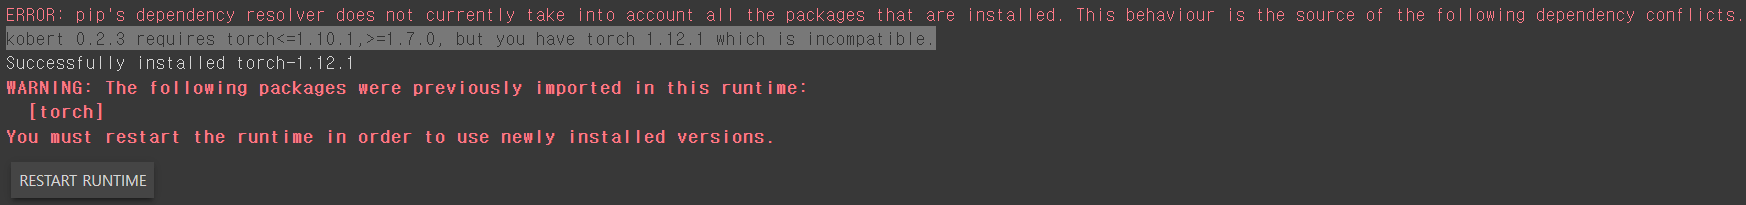

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gluonnlp pandas tqdm
!pip install mxnet
!pip install sentencepiece==0.1.91
!pip install transformers==4.8.1
# kobert 0.2.3 requires torch<=1.10.1,>=1.7.0, but you have torch 1.12.1 which is incompatible. => 이 말 때문에 버전을 맞추는 이유입니다.
!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install --no-cache-dir transformers sentencepiece
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model
#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel

#GPU 사용 시
device = torch.device("cuda:0")

In [ ]:
#오버샘플링 사용을 위한 추가 패키지 설치
!pip install imblearn
from imblearn.over_sampling import SMOTE

In [ ]:
from kobert import get_pytorch_kobert_model
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel, vocab  = get_pytorch_kobert_model()

Downloading:   0%|          | 0.00/371k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/432 [00:00<?, ?B/s]

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
def df_newlabel(df):
  df2 = pd.melt(df, id_vars = df.columns[~df.columns.str.contains('competency')])

  #역량명 숫자로 변경
  df2['variable'] = [int(var[-1]) for var in df2['variable']]
  df2.rename(columns = {'variable': 'label', 'value': 'score'}, inplace = True)

  return df2

In [ ]:
def df_preprocessing(df, column_list : list):
  df1 = df.loc[:, column_list]

  #특수문자 및 불필요한 공백제거
  df1['student_assessment'] = df1['student_assessment'].str.replace("[^0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
  df1['student_assessment'] = df1['student_assessment'].str.replace(" +"," ")

  add_column = ['\t'.join(list(map(str, df1.loc[x, column_list].tolist()))) for x in range(len(df1))]
  score_list = df['score'] - 1

  data = [[add_column[i], score_list[i]] for i in range(len(df1))]

  return data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/PROJECT/1. data/df_3points_subject_concepts.csv")

#사용할 칼럼명 리스트로 지정
column_list = ['label', 'program_category', 'mission_category', 'student_assessment']

#사용할 역량번호 지정
target_number = 1

df2 = df_newlabel(df)
data = df_preprocessing(df2, column_list)
data[:5]

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):

        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))


    def __len__(self):
        return (len(self.labels))

In [ ]:
#클래스 재생성
class BERTOverDataset(Dataset):
  def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len, pad, pair):
    transform = nlp.data.BERTSentenceTransform(
        bert_tokenizer, max_seq_length = max_len, vocab = vocab, pad = pad, pair = pair)

    self.sentences = [transform([i[sent_idx]]) for i in dataset]
    self.labels = [np.int32(i[label_idx]) for i in dataset]

    self.sentences1 = [self.sentences[i][0] for i in range(len(self.sentences))]

    smote = SMOTE(random_state = 2022)
    self.sen1_over, self.labels_over = smote.fit_resample(self.sentences1, self.labels)

    self.sen1_over = [np.array(sen) for sen in self.sen1_over]
    self.sen2_over = [sum(sen != 1) for sen in self.sen1_over]
    self.sen3_over = [np.zeros(max_len) for _ in self.sen1_over]

    self.sen_over = [(self.sen1_over[i], np.array(self.sen2_over[i]), self.sen3_over[i]) for i in range(len(self.sen1_over))]

  def __getitem__(self, i):
    return (self.sen_over[i] + (self.labels_over[i], ))

  def __len__(self):
    return (len(self.labels_over))

In [ ]:
# Setting parameters
max_len = 256
batch_size = 40
warmup_ratio = 0.1
num_epochs = 50
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
#train & test 데이터로 나누기
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=34)

In [ ]:
dataset_train

In [ ]:
tok=tokenizer.tokenize
data_train = BERTOverDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTOverDataset(dataset_test,0, 1, tok, vocab,  max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5, shuffle=True)

In [ ]:
dir(train_dataloader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_is_protocol',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.hidden1 = nn.Linear(hidden_size , 256)
        self.relu1 = nn.ReLU()
        self.hidden2 = nn.Linear(256 , 128)
        self.relu2 = nn.ReLU()
        self.classifier = nn.Linear(128 , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler) # 768 dim

        hidden1_out = self.relu1(self.hidden1(out))
        hidden2_out = self.relu2(self.hidden2(hidden1_out))
        return self.classifier(hidden2_out)

In [ ]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.3).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
# 돌리기 전에 GPU 최적화
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_history=[]
test_history=[]
loss_history=[]
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        # print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    #train_history.append(train_acc / (batch_id+1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)

    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))

<ipython-input-36-6a96544cc4d5>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.1017167568206787 train acc 0.225
epoch 1 batch id 201 loss 1.0570727586746216 train acc 0.4608208955223881
epoch 1 batch id 401 loss 0.9007512331008911 train acc 0.5832917705735662
epoch 1 batch id 601 loss 0.7621575593948364 train acc 0.6314059900166389
epoch 1 batch id 801 loss 0.6439598202705383 train acc 0.6557116104868914
epoch 1 batch id 1001 loss 0.6400141716003418 train acc 0.6696303696303697
epoch 1 train acc 0.6811916776803234


<ipython-input-36-6a96544cc4d5>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 1 test acc 0.7100877192982449


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.5438047647476196 train acc 0.775
epoch 2 batch id 201 loss 0.40222564339637756 train acc 0.7468905472636815
epoch 2 batch id 401 loss 0.5673054456710815 train acc 0.7468204488778044
epoch 2 batch id 601 loss 0.5383986830711365 train acc 0.7438435940099825
epoch 2 batch id 801 loss 0.4466973841190338 train acc 0.743976279650436
epoch 2 batch id 1001 loss 0.472039133310318 train acc 0.7458041958041953
epoch 2 train acc 0.7460511033681764


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 2 test acc 0.734703947368421


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.7023351788520813 train acc 0.7
epoch 3 batch id 201 loss 0.6127676963806152 train acc 0.757089552238806
epoch 3 batch id 401 loss 0.48463940620422363 train acc 0.7575436408977557
epoch 3 batch id 601 loss 0.3596824109554291 train acc 0.76206322795341
epoch 3 batch id 801 loss 0.41794174909591675 train acc 0.7631086142322092
epoch 3 batch id 1001 loss 0.30158546566963196 train acc 0.7640109890109883
epoch 3 train acc 0.764602106612199


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 3 test acc 0.7171326754385963


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.3389321267604828 train acc 0.85
epoch 4 batch id 201 loss 0.34675151109695435 train acc 0.7886815920398013
epoch 4 batch id 401 loss 0.4170960783958435 train acc 0.7857855361596017
epoch 4 batch id 601 loss 0.516179084777832 train acc 0.7829034941763727
epoch 4 batch id 801 loss 0.6598507165908813 train acc 0.7822409488139831
epoch 4 batch id 1001 loss 0.7842841148376465 train acc 0.7814185814185811
epoch 4 train acc 0.7810615162801874


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 4 test acc 0.7342379385964911


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.4276917576789856 train acc 0.825
epoch 5 batch id 201 loss 0.3399460017681122 train acc 0.8033582089552237
epoch 5 batch id 401 loss 0.34584763646125793 train acc 0.8043017456359103
epoch 5 batch id 601 loss 0.4994891285896301 train acc 0.8040765391014975
epoch 5 batch id 801 loss 0.40357404947280884 train acc 0.8014669163545568
epoch 5 batch id 1001 loss 0.49078670144081116 train acc 0.8003746253746251
epoch 5 train acc 0.7999259081260769


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 5 test acc 0.7301809210526317


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.4435085654258728 train acc 0.8
epoch 6 batch id 201 loss 0.4870987832546234 train acc 0.8310945273631842
epoch 6 batch id 401 loss 0.4570940434932709 train acc 0.829551122194514
epoch 6 batch id 601 loss 0.49191540479660034 train acc 0.826913477537438
epoch 6 batch id 801 loss 0.21974137425422668 train acc 0.8240324594257185
epoch 6 batch id 1001 loss 0.3808949291706085 train acc 0.8235764235764242
epoch 6 train acc 0.8226090352036534


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 6 test acc 0.7404057017543861


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.34778133034706116 train acc 0.825
epoch 7 batch id 201 loss 0.17207273840904236 train acc 0.8536069651741295
epoch 7 batch id 401 loss 0.3060862421989441 train acc 0.8564214463840396
epoch 7 batch id 601 loss 0.44226664304733276 train acc 0.8544509151414307
epoch 7 batch id 801 loss 0.3388817608356476 train acc 0.8556179775280899
epoch 7 batch id 1001 loss 0.461137056350708 train acc 0.8555444555444556
epoch 7 train acc 0.8543123473106654


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 7 test acc 0.7333607456140347


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.23890528082847595 train acc 0.925
epoch 8 batch id 201 loss 0.1997285932302475 train acc 0.8962686567164181
epoch 8 batch id 401 loss 0.3741191029548645 train acc 0.894887780548629
epoch 8 batch id 601 loss 0.31672394275665283 train acc 0.8910565723793675
epoch 8 batch id 801 loss 0.46512752771377563 train acc 0.8912921348314597
epoch 8 batch id 1001 loss 0.26555585861206055 train acc 0.8890359640359634
epoch 8 train acc 0.8869718450879084


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 8 test acc 0.7123355263157894


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.19044199585914612 train acc 0.925
epoch 9 batch id 201 loss 0.22186148166656494 train acc 0.9166666666666669
epoch 9 batch id 401 loss 0.18050462007522583 train acc 0.9172693266832919
epoch 9 batch id 601 loss 0.20054399967193604 train acc 0.9157237936772034
epoch 9 batch id 801 loss 0.1873438060283661 train acc 0.9150436953807731
epoch 9 batch id 1001 loss 0.2054639607667923 train acc 0.9145104895104886
epoch 9 train acc 0.9127878569426086


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 9 test acc 0.7063048245614038


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.16318579018115997 train acc 0.95
epoch 10 batch id 201 loss 0.2711047828197479 train acc 0.9348258706467658
epoch 10 batch id 401 loss 0.17745158076286316 train acc 0.9301745635910226
epoch 10 batch id 601 loss 0.09664060920476913 train acc 0.928577371048253
epoch 10 batch id 801 loss 0.19888146221637726 train acc 0.9297128589263413
epoch 10 batch id 1001 loss 0.0953061431646347 train acc 0.9292207792207793
epoch 10 train acc 0.9279516600584711


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 10 test acc 0.7210800438596492


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.14634694159030914 train acc 0.975
epoch 11 batch id 201 loss 0.06676371395587921 train acc 0.9456467661691536
epoch 11 batch id 401 loss 0.10862831771373749 train acc 0.9437655860349127
epoch 11 batch id 601 loss 0.16588763892650604 train acc 0.943801996672214
epoch 11 batch id 801 loss 0.0630996897816658 train acc 0.9423220973782783
epoch 11 batch id 1001 loss 0.1405034214258194 train acc 0.9405594405594422
epoch 11 train acc 0.9396761984861236


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 11 test acc 0.7169682017543861


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.15361329913139343 train acc 0.975
epoch 12 batch id 201 loss 0.016130510717630386 train acc 0.9527363184079589
epoch 12 batch id 401 loss 0.37218526005744934 train acc 0.9518703241895261
epoch 12 batch id 601 loss 0.08515758812427521 train acc 0.9502079866888536
epoch 12 batch id 801 loss 0.030823102220892906 train acc 0.949375780274659
epoch 12 batch id 1001 loss 0.25562167167663574 train acc 0.9487012987013014
epoch 12 train acc 0.9486373102647309


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 12 test acc 0.7177357456140357


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.04118505120277405 train acc 1.0
epoch 13 batch id 201 loss 0.03435292840003967 train acc 0.9600746268656702
epoch 13 batch id 401 loss 0.10399508476257324 train acc 0.9592269326683296
epoch 13 batch id 601 loss 0.08363153785467148 train acc 0.9562396006655588
epoch 13 batch id 801 loss 0.06410279124975204 train acc 0.9559612983770325
epoch 13 batch id 1001 loss 0.18932946026325226 train acc 0.9550949050949099
epoch 13 train acc 0.9543333733829978


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 13 test acc 0.7116776315789481


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.013376357033848763 train acc 1.0
epoch 14 batch id 201 loss 0.03915310651063919 train acc 0.9609452736318397
epoch 14 batch id 401 loss 0.08313523232936859 train acc 0.9610349127182056
epoch 14 batch id 601 loss 0.09374390542507172 train acc 0.9608153078203028
epoch 14 batch id 801 loss 0.22838518023490906 train acc 0.9597690387016272
epoch 14 batch id 1001 loss 0.15864714980125427 train acc 0.9594905094905146
epoch 14 train acc 0.9593796307421241


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 14 test acc 0.7150219298245613


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.1485740840435028 train acc 0.925
epoch 15 batch id 201 loss 0.008742861449718475 train acc 0.967910447761193
epoch 15 batch id 401 loss 0.11650178581476212 train acc 0.9663965087281802
epoch 15 batch id 601 loss 0.18028581142425537 train acc 0.9653494176372743
epoch 15 batch id 801 loss 0.23527267575263977 train acc 0.965012484394513
epoch 15 batch id 1001 loss 0.029835671186447144 train acc 0.9643856143856215
epoch 15 train acc 0.9643858384396684


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 15 test acc 0.7099506578947371


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.05306854099035263 train acc 0.975
epoch 16 batch id 201 loss 0.061275314539670944 train acc 0.9752487562189038
epoch 16 batch id 401 loss 0.10735230147838593 train acc 0.9740648379052372
epoch 16 batch id 601 loss 0.01816520467400551 train acc 0.9717138103161428
epoch 16 batch id 801 loss 0.11671749502420425 train acc 0.9707553058676713
epoch 16 batch id 1001 loss 0.29020771384239197 train acc 0.9700299700299766
epoch 16 train acc 0.9691968040370105


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 16 test acc 0.7260416666666664


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.10715267807245255 train acc 0.95
epoch 17 batch id 201 loss 0.3543071150779724 train acc 0.9783582089552224
epoch 17 batch id 401 loss 0.0018963798647746444 train acc 0.9748129675810475
epoch 17 batch id 601 loss 0.014463691040873528 train acc 0.9734193011647281
epoch 17 batch id 801 loss 0.026752274483442307 train acc 0.9737203495630515
epoch 17 batch id 1001 loss 0.3004460036754608 train acc 0.973451548451555
epoch 17 train acc 0.9730445752733422


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 17 test acc 0.7318804824561402


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.24151721596717834 train acc 0.95
epoch 18 batch id 201 loss 0.19718043506145477 train acc 0.9766169154228838
epoch 18 batch id 401 loss 0.04403974860906601 train acc 0.9767456359102255
epoch 18 batch id 601 loss 0.0802532508969307 train acc 0.9754159733777082
epoch 18 batch id 801 loss 0.15635094046592712 train acc 0.9750312109862742
epoch 18 batch id 1001 loss 0.0908583477139473 train acc 0.9738261738261824
epoch 18 train acc 0.9739697224558495


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 18 test acc 0.7279057017543868


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.035527508705854416 train acc 1.0
epoch 19 batch id 201 loss 0.005809093359857798 train acc 0.9793532338308444
epoch 19 batch id 401 loss 0.2246818244457245 train acc 0.9800498753117217
epoch 19 batch id 601 loss 0.14322158694267273 train acc 0.9799500831946785
epoch 19 batch id 801 loss 0.08107805997133255 train acc 0.9799001248439501
epoch 19 batch id 1001 loss 0.07561932504177094 train acc 0.979020979020986
epoch 19 train acc 0.9786605390684467


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 19 test acc 0.7076480263157896


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.007348415441811085 train acc 1.0
epoch 20 batch id 201 loss 0.0036182322073727846 train acc 0.9844527363184061
epoch 20 batch id 401 loss 0.06050135940313339 train acc 0.9830423940149635
epoch 20 batch id 601 loss 0.08994241803884506 train acc 0.9816971713810357
epoch 20 batch id 801 loss 0.0199610386043787 train acc 0.9812734082397059
epoch 20 batch id 1001 loss 0.09901021420955658 train acc 0.980669330669338
epoch 20 train acc 0.980214465937766


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 20 test acc 0.7216557017543861


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 0.00239363219588995 train acc 1.0
epoch 21 batch id 201 loss 0.027215102687478065 train acc 0.9858208955223865
epoch 21 batch id 401 loss 0.005861632991582155 train acc 0.9837281795511231
epoch 21 batch id 601 loss 0.026034126058220863 train acc 0.9827371048252952
epoch 21 batch id 801 loss 0.009118080139160156 train acc 0.9824594257178587
epoch 21 batch id 1001 loss 0.102273128926754 train acc 0.98231768231769
epoch 21 train acc 0.9817934238455724


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 21 test acc 0.710800438596491


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 0.00372278387658298 train acc 1.0
epoch 22 batch id 201 loss 0.20389561355113983 train acc 0.9880597014925363
epoch 22 batch id 401 loss 0.000832450925372541 train acc 0.9865336658354127
epoch 22 batch id 601 loss 0.0022994298487901688 train acc 0.9857321131447621
epoch 22 batch id 801 loss 0.06965973228216171 train acc 0.9855493133583076
epoch 22 batch id 1001 loss 0.07716672122478485 train acc 0.9853396603396674
epoch 22 train acc 0.9848612279226262


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 22 test acc 0.7266995614035089


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 23 batch id 1 loss 0.005060949362814426 train acc 1.0
epoch 23 batch id 201 loss 0.004952941555529833 train acc 0.9884328358208943
epoch 23 batch id 401 loss 0.0018322430551052094 train acc 0.9875311720698263
epoch 23 batch id 601 loss 0.08975706994533539 train acc 0.9867304492512511
epoch 23 batch id 801 loss 0.21216166019439697 train acc 0.9863607990012541
epoch 23 batch id 1001 loss 0.12415780872106552 train acc 0.9868631368631431
epoch 23 train acc 0.9864381833473528


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 23 test acc 0.7186677631578948


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 24 batch id 1 loss 0.0034569837152957916 train acc 1.0
epoch 24 batch id 201 loss 0.0010122025851160288 train acc 0.9910447761194019
epoch 24 batch id 401 loss 0.0672229677438736 train acc 0.989650872817956
epoch 24 batch id 601 loss 0.01720970682799816 train acc 0.9890183028286226
epoch 24 batch id 801 loss 0.004236584063619375 train acc 0.9886704119850236
epoch 24 batch id 1001 loss 0.005389336962252855 train acc 0.9888361638361693
epoch 24 train acc 0.9888351555929372


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 24 test acc 0.7231359649122813


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 25 batch id 1 loss 0.0035844899248331785 train acc 1.0
epoch 25 batch id 201 loss 0.09134367853403091 train acc 0.9909203980099491
epoch 25 batch id 401 loss 0.0057221706956624985 train acc 0.9890274314214477
epoch 25 batch id 601 loss 0.0019282425055280328 train acc 0.9889351081530813
epoch 25 batch id 801 loss 0.004067698959261179 train acc 0.989044943820229
epoch 25 batch id 1001 loss 0.016406428068876266 train acc 0.9891358641358693
epoch 25 train acc 0.989192598822541


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 25 test acc 0.7316063596491231


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 26 batch id 1 loss 0.0008717264863662422 train acc 1.0
epoch 26 batch id 201 loss 0.0006598674808628857 train acc 0.9916666666666658
epoch 26 batch id 401 loss 0.002634765114635229 train acc 0.9913341645885299
epoch 26 batch id 601 loss 0.0011452882317826152 train acc 0.9911397670549118
epoch 26 batch id 801 loss 0.0009303910774178803 train acc 0.9911985018726637
epoch 26 batch id 1001 loss 0.08342456817626953 train acc 0.990709290709296
epoch 26 train acc 0.9909167367535758


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 26 test acc 0.7182017543859646


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 27 batch id 1 loss 0.0011099178809672594 train acc 1.0
epoch 27 batch id 201 loss 0.2523899972438812 train acc 0.9944029850746263
epoch 27 batch id 401 loss 0.00336417811922729 train acc 0.9938279301745649
epoch 27 batch id 601 loss 0.04362693801522255 train acc 0.9931364392678899
epoch 27 batch id 801 loss 0.00018811605696100742 train acc 0.992634207240953
epoch 27 batch id 1001 loss 0.002643485087901354 train acc 0.9922827172827222
epoch 27 train acc 0.9920311185870494


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 27 test acc 0.7288925438596483


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 28 batch id 1 loss 0.001131740165874362 train acc 1.0
epoch 28 batch id 201 loss 0.0005285875522531569 train acc 0.9937810945273625
epoch 28 batch id 401 loss 0.001098060398362577 train acc 0.9937032418952626
epoch 28 batch id 601 loss 0.0153378676623106 train acc 0.9932612312812006
epoch 28 batch id 801 loss 0.002647559391334653 train acc 0.9927590511860213
epoch 28 batch id 1001 loss 0.0005728270043618977 train acc 0.992507492507497
epoch 28 train acc 0.9928301093355778


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 28 test acc 0.7313596491228066


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 29 batch id 1 loss 0.0014599306741729379 train acc 1.0
epoch 29 batch id 201 loss 0.00048192794201895595 train acc 0.9946517412935318
epoch 29 batch id 401 loss 0.00037156703183427453 train acc 0.9949501246882796
epoch 29 batch id 601 loss 0.0019246317679062486 train acc 0.9940515806988377
epoch 29 batch id 801 loss 0.00040261639514937997 train acc 0.9936641697877684
epoch 29 batch id 1001 loss 0.002389008877798915 train acc 0.9936063936063972
epoch 29 train acc 0.9929352396972243


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 29 test acc 0.7280427631578947


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 30 batch id 1 loss 0.00034077424788847566 train acc 1.0
epoch 30 batch id 201 loss 0.00038731301901862025 train acc 0.9935323383084571
epoch 30 batch id 401 loss 0.08362691104412079 train acc 0.9941396508728192
epoch 30 batch id 601 loss 0.02466263249516487 train acc 0.9940099833610672
epoch 30 batch id 801 loss 0.00024603845668025315 train acc 0.9946004993757828
epoch 30 batch id 1001 loss 0.13242633640766144 train acc 0.9943306693306725
epoch 30 train acc 0.9944280908326336


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 30 test acc 0.7312225877192983


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 31 batch id 1 loss 0.00024717350606806576 train acc 1.0
epoch 31 batch id 201 loss 0.00014242733595892787 train acc 0.9962686567164172
epoch 31 batch id 401 loss 0.0016416057478636503 train acc 0.9951995012468836
epoch 31 batch id 601 loss 0.00046318318345583975 train acc 0.9948419301164744
epoch 31 batch id 801 loss 0.11831218004226685 train acc 0.9951310861423243
epoch 31 batch id 1001 loss 0.10196544975042343 train acc 0.9951548451548476
epoch 31 train acc 0.9950378469301937


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 31 test acc 0.7304550438596491


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 32 batch id 1 loss 0.0006567946984432638 train acc 1.0
epoch 32 batch id 201 loss 0.0003974636201746762 train acc 0.9953980099502482
epoch 32 batch id 401 loss 0.10692177712917328 train acc 0.9950124688279312
epoch 32 batch id 601 loss 0.0005372531595639884 train acc 0.9950915141430968
epoch 32 batch id 801 loss 0.00022055480803828686 train acc 0.9952247191011261
epoch 32 batch id 1001 loss 0.00014373197336681187 train acc 0.9948551448551479
epoch 32 train acc 0.9948275862068967


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 32 test acc 0.7243421052631577


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 33 batch id 1 loss 0.000260232831351459 train acc 1.0
epoch 33 batch id 201 loss 0.00017899609520100057 train acc 0.9967661691542286
epoch 33 batch id 401 loss 0.19148144125938416 train acc 0.9964463840399014
epoch 33 batch id 601 loss 0.0003354734508320689 train acc 0.9962978369384378
epoch 33 batch id 801 loss 0.00304773123934865 train acc 0.9964419475655452
epoch 33 batch id 1001 loss 0.0006572320125997066 train acc 0.9962787212787237
epoch 33 train acc 0.99594196804037


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 33 test acc 0.7278782894736843


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 34 batch id 1 loss 0.00011507681483635679 train acc 1.0
epoch 34 batch id 201 loss 5.604793113889173e-05 train acc 0.9966417910447757
epoch 34 batch id 401 loss 4.8301615606760606e-05 train acc 0.9971321695760602
epoch 34 batch id 601 loss 0.0012939878506585956 train acc 0.9968386023294521
epoch 34 batch id 801 loss 0.0004015875165350735 train acc 0.9967852684144836
epoch 34 batch id 1001 loss 0.0001313415268668905 train acc 0.9966533466533487
epoch 34 train acc 0.9966778805719093


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 34 test acc 0.7292489035087718


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 35 batch id 1 loss 0.0002709450200200081 train acc 1.0
epoch 35 batch id 201 loss 0.1422850638628006 train acc 0.9965174129353229
epoch 35 batch id 401 loss 0.00012707019050139934 train acc 0.9966957605985045
epoch 35 batch id 601 loss 0.0001624890574021265 train acc 0.9968386023294523
epoch 35 batch id 801 loss 4.585255010169931e-05 train acc 0.9967852684144837
epoch 35 batch id 1001 loss 4.836085281567648e-05 train acc 0.9967282717282738
epoch 35 train acc 0.9963835155592932


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 35 test acc 0.7318804824561403


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 36 batch id 1 loss 0.025365635752677917 train acc 0.975
epoch 36 batch id 201 loss 7.451898272847757e-05 train acc 0.9975124378109449
epoch 36 batch id 401 loss 0.0003887308412231505 train acc 0.9975062344139658
epoch 36 batch id 601 loss 4.227882163831964e-05 train acc 0.9973377703826968
epoch 36 batch id 801 loss 7.590462337248027e-05 train acc 0.997253433208491
epoch 36 batch id 1001 loss 4.614747376763262e-05 train acc 0.997177822177824
epoch 36 train acc 0.9970142977291838


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 36 test acc 0.7271929824561406


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 37 batch id 1 loss 7.283810555236414e-05 train acc 1.0
epoch 37 batch id 201 loss 0.00012422920553945005 train acc 0.9968905472636812
epoch 37 batch id 401 loss 0.00011671053653117269 train acc 0.9973192019950128
epoch 37 batch id 601 loss 4.974353942088783e-05 train acc 0.9969633943427632
epoch 37 batch id 801 loss 3.679807559819892e-05 train acc 0.9971285892634221
epoch 37 batch id 1001 loss 2.709832915570587e-05 train acc 0.9972527472527487
epoch 37 train acc 0.9971825063078218


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 37 test acc 0.7306469298245614


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 38 batch id 1 loss 3.752591510419734e-05 train acc 1.0
epoch 38 batch id 201 loss 4.465406891540624e-05 train acc 0.9976368159203978
epoch 38 batch id 401 loss 3.920613380614668e-05 train acc 0.9973815461346641
epoch 38 batch id 601 loss 7.331536471610889e-05 train acc 0.9976289517470892
epoch 38 batch id 801 loss 0.00010001605551224202 train acc 0.9974406991260939
epoch 38 batch id 1001 loss 0.0007880543125793338 train acc 0.9974275724275741
epoch 38 train acc 0.9974348191757786


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 38 test acc 0.7296326754385966


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 39 batch id 1 loss 1.9502354916767217e-05 train acc 1.0
epoch 39 batch id 201 loss 2.3284021153813228e-05 train acc 0.9980099502487559
epoch 39 batch id 401 loss 7.266753527801484e-05 train acc 0.9979426433915216
epoch 39 batch id 601 loss 2.2541860744240694e-05 train acc 0.9977537437604004
epoch 39 batch id 801 loss 3.4416869311826304e-05 train acc 0.9978464419475668
epoch 39 batch id 1001 loss 1.56996011355659e-05 train acc 0.9978771228771243
epoch 39 train acc 0.9978763666947014


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 39 test acc 0.7294407894736841


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 40 batch id 1 loss 6.421625585062429e-05 train acc 1.0
epoch 40 batch id 201 loss 2.041674633801449e-05 train acc 0.997014925373134
epoch 40 batch id 401 loss 1.4453937183134258e-05 train acc 0.9973192019950128
epoch 40 batch id 601 loss 0.002224566647782922 train acc 0.9977953410981703
epoch 40 batch id 801 loss 1.639973561395891e-05 train acc 0.9979088639201006
epoch 40 batch id 1001 loss 1.2376780432532541e-05 train acc 0.9978021978021989
epoch 40 train acc 0.997687132043734


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 40 test acc 0.7344846491228071


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 41 batch id 1 loss 1.4918754459358752e-05 train acc 1.0
epoch 41 batch id 201 loss 1.6441726984339766e-05 train acc 0.9975124378109449
epoch 41 batch id 401 loss 5.483616405399516e-05 train acc 0.9976932668329183
epoch 41 batch id 601 loss 9.810842129809316e-06 train acc 0.9976705490848595
epoch 41 batch id 801 loss 0.00019151667947880924 train acc 0.9975967540574295
epoch 41 batch id 1001 loss 2.382580714765936e-05 train acc 0.9976523476523491
epoch 41 train acc 0.9976871320437344


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 41 test acc 0.7308114035087714


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 42 batch id 1 loss 1.6110760043375194e-05 train acc 1.0
epoch 42 batch id 201 loss 0.000879845698364079 train acc 0.9981343283582087
epoch 42 batch id 401 loss 2.7050071366829798e-05 train acc 0.9980673316708232
epoch 42 batch id 601 loss 4.681710561271757e-05 train acc 0.9980033277870223
epoch 42 batch id 801 loss 1.0266778190270998e-05 train acc 0.9980337078651694
epoch 42 batch id 1001 loss 2.808023418765515e-05 train acc 0.9980019980019992
epoch 42 train acc 0.9980445752733392


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 42 test acc 0.7327850877192987


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 43 batch id 1 loss 9.250545190297998e-06 train acc 1.0
epoch 43 batch id 201 loss 1.5711368178017437e-05 train acc 0.9982587064676615
epoch 43 batch id 401 loss 0.0018204068765044212 train acc 0.9980049875311725
epoch 43 batch id 601 loss 1.0102868145622779e-05 train acc 0.9979201331114816
epoch 43 batch id 801 loss 6.742840923834592e-05 train acc 0.9980649188514367
epoch 43 batch id 1001 loss 1.1911854016943835e-05 train acc 0.9980269730269742
epoch 43 train acc 0.9979394449116905


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 43 test acc 0.729194078947368


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 44 batch id 1 loss 1.5777033695485443e-05 train acc 1.0
epoch 44 batch id 201 loss 3.48812245647423e-05 train acc 0.9991293532338308
epoch 44 batch id 401 loss 1.2460184734663926e-05 train acc 0.9985037406483795
epoch 44 batch id 601 loss 0.015018999576568604 train acc 0.9983361064891855
epoch 44 batch id 801 loss 1.2740047168335877e-05 train acc 0.998096129837704
epoch 44 batch id 1001 loss 1.0257865142193623e-05 train acc 0.9981268731268744
epoch 44 train acc 0.9981727341903966


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 44 test acc 0.7305646929824566


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 45 batch id 1 loss 1.0421765182400122e-05 train acc 1.0
epoch 45 batch id 201 loss 0.0002971302601508796 train acc 0.9987562189054725
epoch 45 batch id 401 loss 1.4504359569400549e-05 train acc 0.9984413965087287
epoch 45 batch id 601 loss 0.011165144853293896 train acc 0.9983361064891857
epoch 45 batch id 801 loss 9.366763151774649e-06 train acc 0.9981897627965056
epoch 45 batch id 1001 loss 0.02021697722375393 train acc 0.9981518481518495
epoch 45 train acc 0.9982548359966366


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 45 test acc 0.7303728070175443


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 46 batch id 1 loss 7.855830517655704e-06 train acc 1.0
epoch 46 batch id 201 loss 9.885338840831537e-06 train acc 0.9986318407960197
epoch 46 batch id 401 loss 6.261425824050093e-06 train acc 0.998379052369078
epoch 46 batch id 601 loss 1.3118714377924334e-05 train acc 0.998252911813645
epoch 46 batch id 801 loss 0.014059795066714287 train acc 0.9983458177278413
epoch 46 batch id 1001 loss 1.019823866954539e-05 train acc 0.9984265734265745
epoch 46 train acc 0.9983809924306138


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 46 test acc 0.7302083333333329


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 47 batch id 1 loss 1.6118605344672687e-05 train acc 1.0
epoch 47 batch id 201 loss 8.460790922981687e-06 train acc 0.9986318407960197
epoch 47 batch id 401 loss 7.381964678643271e-06 train acc 0.9980049875311725
epoch 47 batch id 601 loss 6.7621126618178096e-06 train acc 0.9980865224625632
epoch 47 batch id 801 loss 1.0454550647409633e-05 train acc 0.9982521847690395
epoch 47 batch id 1001 loss 6.5385802372475155e-06 train acc 0.9982767232767242
epoch 47 train acc 0.9983389402859547


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 47 test acc 0.7311951754385966


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 48 batch id 1 loss 9.107485311687924e-06 train acc 1.0
epoch 48 batch id 201 loss 8.32965724839596e-06 train acc 0.9986318407960196
epoch 48 batch id 401 loss 7.6084688771516085e-06 train acc 0.9985037406483793
epoch 48 batch id 601 loss 7.3134447120537516e-06 train acc 0.9983361064891855
epoch 48 batch id 801 loss 8.08531422080705e-06 train acc 0.9982521847690398
epoch 48 batch id 1001 loss 1.172401516669197e-05 train acc 0.9984265734265744
epoch 48 train acc 0.9984861227922627


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 48 test acc 0.7309758771929823


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 49 batch id 1 loss 8.937640814110637e-06 train acc 1.0
epoch 49 batch id 201 loss 1.626415723876562e-05 train acc 0.9986318407960199
epoch 49 batch id 401 loss 6.771048447262729e-06 train acc 0.9986284289276812
epoch 49 batch id 601 loss 6.9111147240619175e-06 train acc 0.9986688851913484
epoch 49 batch id 801 loss 0.016338784247636795 train acc 0.9987827715355813
epoch 49 batch id 1001 loss 1.089848592528142e-05 train acc 0.9988011988011996
epoch 49 train acc 0.9985912531539107


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 49 test acc 0.7307839912280703


  0%|          | 0/1189 [00:00<?, ?it/s]

epoch 50 batch id 1 loss 6.87535566612496e-06 train acc 1.0
epoch 50 batch id 201 loss 7.331263077503536e-06 train acc 0.9978855721393032
epoch 50 batch id 401 loss 0.0003719524247571826 train acc 0.9981296758104743
epoch 50 batch id 601 loss 8.481675649818499e-06 train acc 0.9982945091514152
epoch 50 batch id 801 loss 8.160841389326379e-05 train acc 0.9983770287141083
epoch 50 batch id 1001 loss 6.976682925596833e-06 train acc 0.9983266733266742
epoch 50 train acc 0.998402018502944


  0%|          | 0/304 [00:00<?, ?it/s]

epoch 50 test acc 0.7309484649122806


In [ ]:
train_history

[0.225,
 0.4608208955223881,
 0.5832917705735662,
 0.6314059900166389,
 0.6557116104868914,
 0.6696303696303697,
 0.775,
 0.7468905472636815,
 0.7468204488778044,
 0.7438435940099825,
 0.743976279650436,
 0.7458041958041953,
 0.7,
 0.757089552238806,
 0.7575436408977557,
 0.76206322795341,
 0.7631086142322092,
 0.7640109890109883,
 0.85,
 0.7886815920398013,
 0.7857855361596017,
 0.7829034941763727,
 0.7822409488139831,
 0.7814185814185811,
 0.825,
 0.8033582089552237,
 0.8043017456359103,
 0.8040765391014975,
 0.8014669163545568,
 0.8003746253746251,
 0.8,
 0.8310945273631842,
 0.829551122194514,
 0.826913477537438,
 0.8240324594257185,
 0.8235764235764242,
 0.825,
 0.8536069651741295,
 0.8564214463840396,
 0.8544509151414307,
 0.8556179775280899,
 0.8555444555444556,
 0.925,
 0.8962686567164181,
 0.894887780548629,
 0.8910565723793675,
 0.8912921348314597,
 0.8890359640359634,
 0.925,
 0.9166666666666669,
 0.9172693266832919,
 0.9157237936772034,
 0.9150436953807731,
 0.9145104895104

In [ ]:
test_history

[0.7100877192982449,
 0.734703947368421,
 0.7171326754385963,
 0.7342379385964911,
 0.7301809210526317,
 0.7404057017543861,
 0.7333607456140347,
 0.7123355263157894,
 0.7063048245614038,
 0.7210800438596492,
 0.7169682017543861,
 0.7177357456140357,
 0.7116776315789481,
 0.7150219298245613,
 0.7099506578947371,
 0.7260416666666664,
 0.7318804824561402,
 0.7279057017543868,
 0.7076480263157896,
 0.7216557017543861,
 0.710800438596491,
 0.7266995614035089,
 0.7186677631578948,
 0.7231359649122813,
 0.7316063596491231,
 0.7182017543859646,
 0.7288925438596483,
 0.7313596491228066,
 0.7280427631578947,
 0.7312225877192983,
 0.7304550438596491,
 0.7243421052631577,
 0.7278782894736843,
 0.7292489035087718,
 0.7318804824561403,
 0.7271929824561406,
 0.7306469298245614,
 0.7296326754385966,
 0.7294407894736841,
 0.7344846491228071,
 0.7308114035087714,
 0.7327850877192987,
 0.729194078947368,
 0.7305646929824566,
 0.7303728070175443,
 0.7302083333333329,
 0.7311951754385966,
 0.7309758771929

In [ ]:
loss_history

[array(1.1017168, dtype=float32),
 array(1.0570728, dtype=float32),
 array(0.90075123, dtype=float32),
 array(0.76215756, dtype=float32),
 array(0.6439598, dtype=float32),
 array(0.6400142, dtype=float32),
 array(0.54380476, dtype=float32),
 array(0.40222564, dtype=float32),
 array(0.56730545, dtype=float32),
 array(0.5383987, dtype=float32),
 array(0.44669738, dtype=float32),
 array(0.47203913, dtype=float32),
 array(0.7023352, dtype=float32),
 array(0.6127677, dtype=float32),
 array(0.4846394, dtype=float32),
 array(0.3596824, dtype=float32),
 array(0.41794175, dtype=float32),
 array(0.30158547, dtype=float32),
 array(0.33893213, dtype=float32),
 array(0.3467515, dtype=float32),
 array(0.41709608, dtype=float32),
 array(0.5161791, dtype=float32),
 array(0.6598507, dtype=float32),
 array(0.7842841, dtype=float32),
 array(0.42769176, dtype=float32),
 array(0.339946, dtype=float32),
 array(0.34584764, dtype=float32),
 array(0.49948913, dtype=float32),
 array(0.40357405, dtype=float32),


In [ ]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()
            print(logits)
            if np.argmax(logits) == 0:
                    test_eval.append("1")
            elif np.argmax(logits) == 1:
                test_eval.append("2")
            elif np.argmax(logits) == 2:
                test_eval.append("3")
            elif np.argmax(logits) == 3:
                test_eval.append("4")
            elif np.argmax(logits) == 4:
                test_eval.append("5")

        print(">> 역량은 : " + test_eval[0] + " 입니다.")
        return test_eval[0]
        # end = 1
        # while end == 1 :
        #     sentence = input("하고싶은 말을 입력해주세요 : ")
        #     if sentence == "stop" :
        #         break
        #     predict(sentence)
        #     print("\n")

In [ ]:
str_list = [['1','자기개발', '하기 싫어', '의견나누기'],
['2','자기개발', '하기 싫어', '의견나누기'],
['3','자기개발', '하기 싫어', '의견나누기'],
['4','자기개발', '하기 싫어', '의견나누기']]
a = []
for i in str_list:
  result = '\t'.join(s for s in i)
  print(result)
  a.append(predict(result))

1	자기개발	하기 싫어	의견나누기
[ 7.741409  -3.9455526 -6.135218 ]
>> 역량은 : 1 입니다.
2	자기개발	하기 싫어	의견나누기
[-1.76921   7.040702 -5.144278]
>> 역량은 : 2 입니다.
3	자기개발	하기 싫어	의견나누기
[-4.369335   8.205849  -2.9332702]
>> 역량은 : 2 입니다.
4	자기개발	하기 싫어	의견나누기
[-2.492292   7.6381035 -4.7663207]
>> 역량은 : 2 입니다.


In [ ]:
a

['1', '2', '2', '2']

In [ ]:
sentence1 = '1\t자기개발\t하기 싫어\t의견나누기'
predict(sentence1)

[ 7.741409  -3.9455526 -6.135218 ]
>> 역량은 : 1 입니다.
하고싶은 말을 입력해주세요 : 2\t자기개발\t하기 싫어\t의견나누기
[-4.906867   7.687403  -1.7680509]
>> 역량은 : 2 입니다.
하고싶은 말을 입력해주세요 : 3\t자기개발\t하기 싫어\t의견나누기
[-4.2818394  7.7316017 -2.5856295]
>> 역량은 : 2 입니다.
하고싶은 말을 입력해주세요 : 4\t자기개발\t하기 싫어\t의견나누기
[-6.046687   0.3670851  5.8497963]
>> 역량은 : 3 입니다.
하고싶은 말을 입력해주세요 : 5\t자기개발\t하기 싫어\t의견나누기
[-5.1991673   7.1406484  -0.88266176]
>> 역량은 : 2 입니다.


KeyboardInterrupt: ignored

In [ ]:
sentence1 = "진로탐색	실습/연습	콤부차에 대한 강의를 잘 듣지 않은 것으로 판단됨.	미션 1에서는 이마만 보여주며 기록할 것이 크게 없음 미션 1에서는 이마만 보여주며 기록할 것이 크게 없음 "
predict(sentence1)

NameError: ignored

In [ ]:
PATH = "/content/drive/MyDrive/PROJECT/"
torch.save(model.state_dict(), PATH + 'model_state_dict123.pt')

In [ ]:
# model 학습후 class(즉 가중치를 만드는 모듈) 성공했을 때에만 모듈화 작업할 예정
PATH = "/content/drive/MyDrive/PROJECT/"
torch.save(model, PATH + 'model1234.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'model_state_dict1234.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')

In [ ]:
model